In [28]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import japanize_matplotlib

# 構造的時系列モデル
## データ生成
- 解析対象のトレンドモデルを作る

In [2]:
num_step = 100
step_size = 0.1

In [3]:
np.random.seed(1)

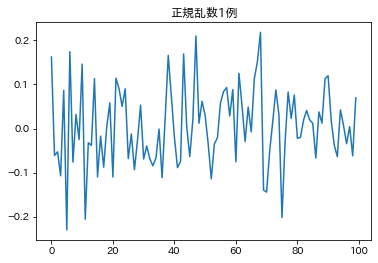

In [4]:
z = np.random.randn(num_step) * step_size

plt.figure()
plt.plot(z)
plt.title("正規乱数1例");

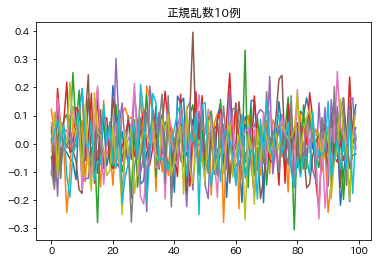

In [5]:
zz = np.random.randn(num_step,10) * step_size

plt.figure()
plt.plot(zz)
plt.title("正規乱数10例");

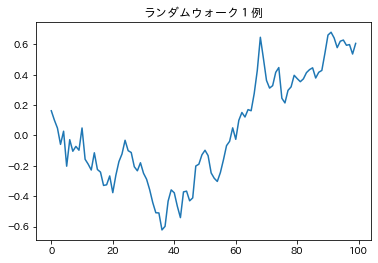

In [6]:
b = np.cumsum(z)

plt.figure()
plt.plot(b)
plt.title("ランダムウォーク１例");

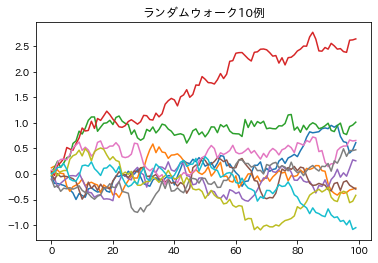

In [7]:
bb = np.cumsum(zz, axis=0)

plt.figure()
plt.plot(bb)
plt.title("ランダムウォーク10例");

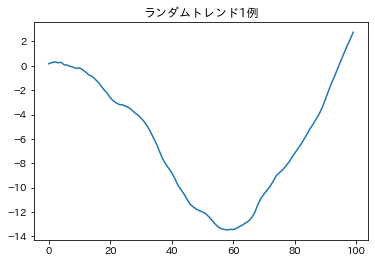

In [8]:
u = np.cumsum(b)

plt.figure()
plt.plot(u)
plt.title("ランダムトレンド1例");

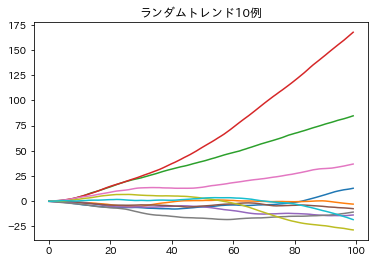

In [9]:
uu = np.cumsum(bb, axis=0)

plt.figure()
plt.plot(uu)
plt.title("ランダムトレンド10例");

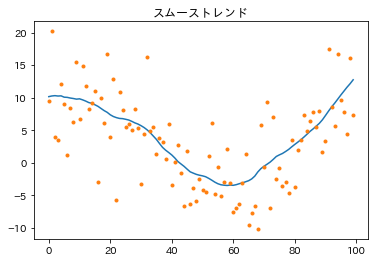

In [10]:
sigma = 5
c = 10
e = np.random.randn(num_step)

u = u + c
y = u + e * sigma

plt.figure()
plt.plot(u)
plt.plot(y, '.')
plt.title("スムーストレンド");

- ランダムウォーク:乱数の累積和でできる系列データ
- ランダムトレンド:ランダムウォークの累積和でできる系列データ
- トレンドモデルに観測ノイズが混ざったのがスムースモデル

## 推論

In [27]:
import numpyro
import numpyro.distributions as dist

import jax
import jax.numpy as jnp

import arviz as az
import seaborn as sns

In [22]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(5)#一回推論した後に数字変える場合はカーネルリスタートする

In [23]:
t = np.arange(len(y))
y = jnp.array(y)

### モデリング
- ランダムウォーク
    - $\xi_n\sim\mathcal{N}(\xi_n|0, \sigma_{\xi})$
    - $\beta_{n}=\beta_{n-1}+\xi_{n}$
- ランダムトレンド
    - $\mu_{n} = \mu_{n-1}+\beta_n$
- スムーストレンド
    - $\epsilon_n \sim \mathcal{N}(\epsilon_n|0, \sigma_{\epsilon})$※観測ノイズ
    - $y_n = \mu_n + \epsilon_n$

In [26]:
def model(y_obs):
    num_steps = len(y_obs)
    
    # ランダムウォーク変数の分散パラの事前分布
    sd_b = numpyro.sample("sd_b", dist.HalfNormal(10))
    # ランダムウォーク変数の事前分布
    b = numpyro.sample("b", dist.GaussianRandomWalk(scale=sd_b, num_steps=num_steps))

    #トレンドモデルの初期値（バイアス）の事前分布
    c = numpyro.sample("c", dist.Normal(10))

    # ランダムトレンド（確率変数ではない）
    u = numpyro.deterministic("u", jnp.cumsum(b) + c)
    
    #観測ノイズの分散パラの事前分布
    sd_y = numpyro.sample("sd_y", dist.HalfNormal(10))
    
    #観測モデル（スムーストレンド）
    numpyro.sample("y", dist.Normal(u, sd_y), obs=y_obs)

In [15]:
nuts = numpyro.infer.NUTS(model, target_accept_prob=0.95)
mcmc = numpyro.infer.MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=5)

mcmc.run(jax.random.PRNGKey(1), y)

trace = mcmc.get_samples()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [16]:
idata = az.from_numpyro(mcmc)

In [17]:
az.summary(idata, var_names=["c", "sd_b", "sd_y"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c,9.854,0.835,8.246,11.369,0.012,0.008,5227.0,3984.0,1.00
sd_b,0.099,0.040,0.044,0.177,0.004,0.003,106.0,130.0,1.03
sd_y,4.874,0.358,4.212,5.545,0.004,0.003,6894.0,3854.0,1.00


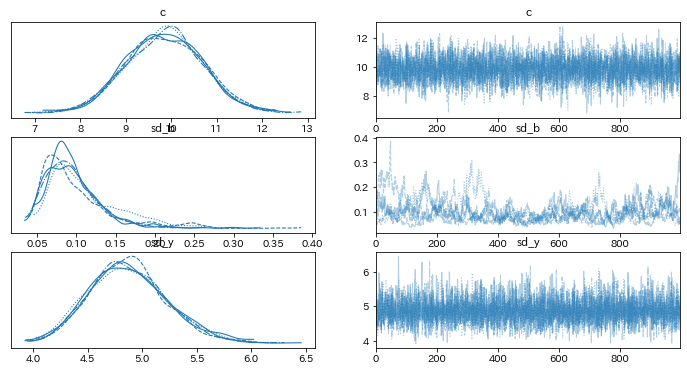

In [18]:
az.plot_trace(idata, var_names=["c", "sd_b", "sd_y"]);

In [19]:
u_samled = trace["u"]

In [20]:
mu = jnp.mean(u_samled, 0)
pi = jnp.percentile(u_samled, np.array([5, 95]), 0)

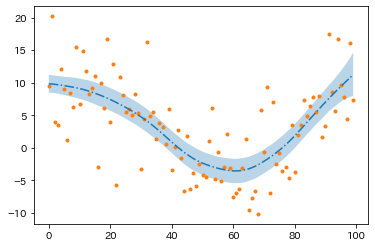

In [21]:
plt.plot(t, y, ".", color="C1")

plt.plot(t, mu, "-.")
plt.fill_between(t, pi[0, :], pi[1, :], alpha=0.3);

# 変化点検出

## データ生成

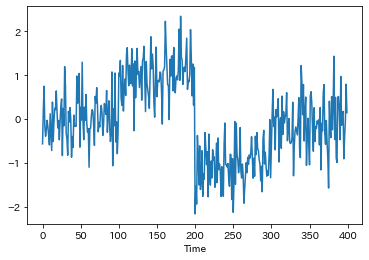

In [30]:
np.random.seed(111)

y0 = np.random.normal(0, 0.5, 100)
y1 = np.random.normal(1, 0.5, 100)
y2 = np.random.normal(-1, 0.5, 100)
y3 = np.random.normal(0, 0.5, 100)

y_obs = np.concatenate([y0, y1, y2, y3])
t_obs = np.arange(len(y_obs))

plt.figure()
plt.plot(t_obs, y_obs)
plt.xlabel("Time");

In [31]:
y_obs = jnp.array(y_obs)

## モデリング

- 今回は累積和が一回（ランダムウォークモデル）
- 乱数をコーシ分布で考える（なめらかじゃない変化も許す）

In [35]:
def model(y_obs):
    num_steps = len(y_obs)
    # ランダム変数の分散パラの事前分布
    sd_b = numpyro.sample("sd_b", dist.HalfNormal(10))
    # ランダム変数の分布
    b = numpyro.sample("b", dist.Cauchy(0, sd_b), sample_shape=(num_steps,))

    # ランダムウォークのバイアスの事前分布
    c = numpyro.sample("c", dist.Normal(0, 10))
    # ランダムウォーク
    u = numpyro.deterministic("u", jnp.cumsum(b) + c)
    
    # 観測ノイズの分散パラの事前分布
    sd_y = numpyro.sample("sd_y", dist.HalfNormal(10))
    
    # 観測モデル
    numpyro.sample("y", dist.Normal(u, sd_y), obs = y_obs)

In [36]:
nuts = numpyro.infer.NUTS(model, target_accept_prob=0.95)
mcmc = numpyro.infer.MCMC(nuts, num_warmup=5000, num_samples=5000,num_chains=5)

mcmc.run(jax.random.PRNGKey(1), y_obs)

trace = mcmc.get_samples()

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [37]:
idata = az.from_numpyro(mcmc)

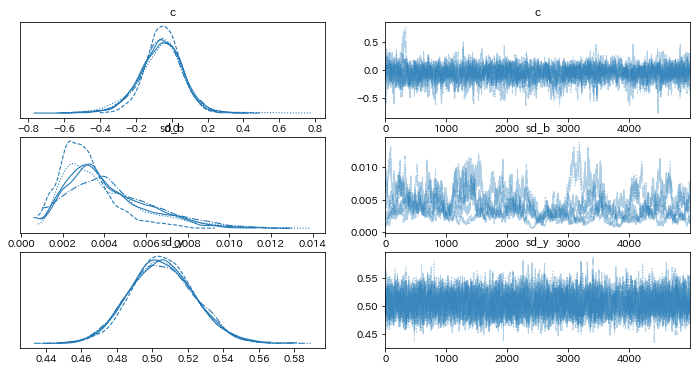

In [38]:
az.plot_trace(idata, var_names=["c", "sd_b", "sd_y"]);

In [40]:
az.summary(idata, var_names=["c", "sd_b", "sd_y"],)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c,-0.059,0.124,-0.293,0.167,0.004,0.003,895.0,1044.0,1.01
sd_b,0.004,0.002,0.001,0.008,0.000,0.000,46.0,235.0,1.10
sd_y,0.506,0.018,0.472,0.540,0.000,0.000,4398.0,9260.0,1.00


## 潜在変数の事前分布の確認 

In [41]:
u_samled = trace["u"]

In [42]:
mu = jnp.mean(u_samled, 0)
pi = jnp.percentile(u_samled, jnp.array([5,95]), 0)

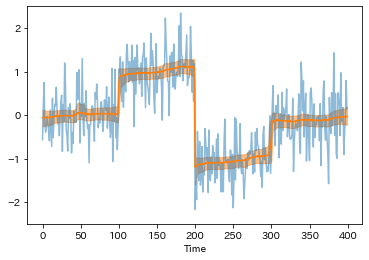

In [46]:
plt.figure()
plt.plot(t_obs, y_obs, color="C0", alpha=0.5)

plt.plot(t_obs, mu, "-,", color="C1")
plt.fill_between(t_obs, pi[0, :], pi[1, :], color="C1", alpha=0.5)

plt.ylim([-2.5, 2.5])
plt.xlabel("Time");

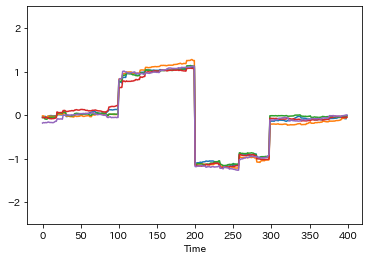

In [47]:
plt.figure()
plt.plot(u_samled[:5, :].T)
plt.ylim([-2.5, 2.5])
plt.xlabel("Time");

# 確率的ボラリティリティモデル
- 分散の変化だけ推論する

In [71]:
# データロード
from numpyro.examples.datasets import SP500, load_dataset
_, fetch = load_dataset(SP500, shuffle=False)
dates, returns = fetch()

In [72]:
dates = pd.to_datetime(dates)

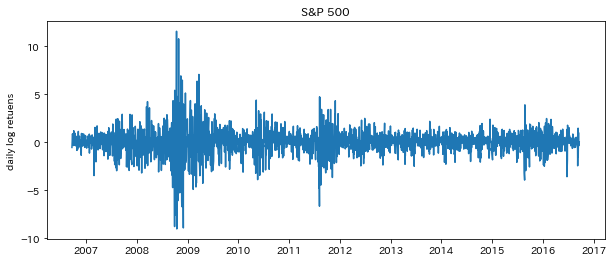

In [73]:
plt.figure(figsize=(10, 4))

plt.plot(dates, returns)
plt.title("S&P 500")
plt.ylabel("daily log retuens");

In [74]:
returns = jnp.array(returns)

## モデリング
- $\xi_n \sim \mathcal{N}(\xi_n|0,\sigma)$
- $\mu_n = \mu_{n-1} + \xi_n$
- $y_n \sim St(\nu,0,\exp(\mu_n))$

In [95]:
def model(returns):
    # ランダムウォーク変数の分散パラの事前分布
    step_size = numpyro.sample("sigma", dist.Exponential(50))
    # ランダムウォークモデル
    s = numpyro.sample("s", dist.GaussianRandomWalk(scale=step_size, num_steps=len(returns)))
    # 観測ノイズの平均パラの事前分布
    nu = numpyro.sample("nu", dist.Exponential(0.1))
    #　観測モデル（スチューデントのT分布）
    numpyro.sample("r", dist.StudentT(df=nu, loc=0.0, scale=jnp.exp(s)), obs=returns)

In [ ]:
nuts = numpyro.infer.NUTS(model, target_accept_prob=0.95)
mcmc = numpyro.infer.MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=4)
# chainsの数でも結果結構変わる

mcmc.run(jax.random.PRNGKey(1), returns)
trace = mcmc.get_samples()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [91]:
idata = az.from_numpyro(mcmc)

In [92]:
az.summary(idata, var_names=["nu", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
nu,12.913,4.577,6.635,20.195,0.123,0.087,1397.0,2469.0,1.00
sigma,0.087,0.008,0.070,0.101,0.001,0.001,63.0,78.0,1.05


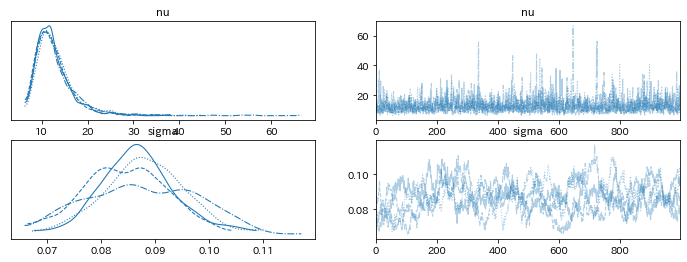

In [93]:
az.plot_trace(idata, var_names=["nu", "sigma"]);

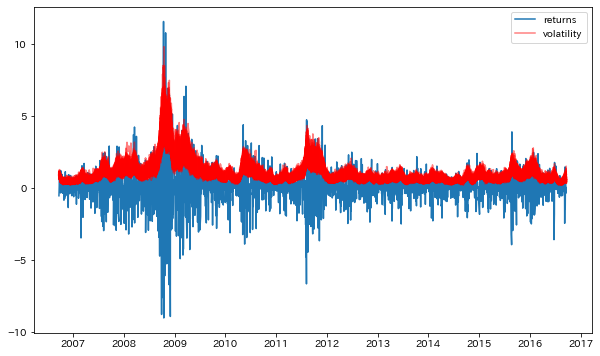

In [94]:
plt.figure(figsize=(10, 6))

plt.plot(dates, returns)
plt.plot(dates, jnp.exp(trace["s"][::20].T), color = "r", alpha = 0.5)
plt.legend(["returns", "volatility"]);